In [2]:
pip install flask

  Using cached flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
Using cached flask-3.1.2-py3-none-any.whl (103 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached click-8.3.0-py3-none-any.whl (107 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
nutrition_df = pd.read_csv('nutrition_data.csv')

In [5]:
nutrition_df.head()

,food,serving(g),calories,protein(g),carbs(g),fibre(g),fats(g),sugar(g),type
0,roti,40,120.0,3.1,18.5,3.9,3.7,3.5,healthy
1,dal,214,222.0,14.0,34.0,13.0,4.2,4.5,healthy
2,rice,158,205.0,4.3,45.0,0.6,0.4,0.1,healthy
3,masala_dosa,97,168.0,3.9,29.0,0.9,3.7,0.2,healthy
4,samosa,100,261.0,3.5,24.0,2.1,17.0,1.6,junk


In [1]:
#Organize Dataset
import os
dataset_path = 'dataset'
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Classes found:", classes)
for c in classes:
    img_count = len(os.listdir(os.path.join(dataset_path, c)))
    print(f"{c}: {img_count} images")

Classes found: ['burger', 'dal', 'kachori', 'maggi', 'margherita_pizza', 'masala_dosa', 'rice', 'roti', 'salad', 'samosa', 'vadapav', 'vegetable_besan_chilla', 'vegetable_sandwich']
burger: 107 images
dal: 127 images
kachori: 120 images
maggi: 129 images
margherita_pizza: 122 images
masala_dosa: 116 images
rice: 99 images
roti: 119 images
salad: 119 images
samosa: 113 images
vadapav: 121 images
vegetable_besan_chilla: 116 images
vegetable_sandwich: 117 images


In [2]:
#Data Loading and Preprocessing
import cv2
import numpy as np
def extract_color_histogram(image, bins=(8,8,8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv],[0,1,2],None,bins,[0,180,0,256,0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()
X = []
y = []
for food_class in classes:
    folder = os.path.join(dataset_path, food_class)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        X.append(extract_color_histogram(img))
        y.append(food_class)
X = np.array(X)
y = np.array(y)
print("Shape of X (features):", X.shape)
print("Shape of y (labels):", y.shape)

Shape of X (features): (1523, 512)
Shape of y (labels): (1523,)


In [3]:
#Data Augmentation
def add_flipped_features(X, y, dataset_path, classes):
    for food_class in classes:
        folder = os.path.join(dataset_path, food_class)
        for img_file in os.listdir(folder):
            img_path = os.path.join(folder, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            flipped = cv2.flip(img, 1)
            X.append(extract_color_histogram(flipped))
            y.append(food_class)
    return np.array(X), np.array(y)
X, y = add_flipped_features(list(X), list(y), dataset_path, classes)
print("Shape after augmentation:", X.shape)

Shape after augmentation: (3046, 512)



Training fold 1...
Fold 1 accuracy: 94.43%
                        precision    recall  f1-score   support

                burger       1.00      0.91      0.95        43
                   dal       0.96      0.92      0.94        51
               kachori       0.95      0.88      0.91        48
                 maggi       0.92      0.96      0.94        51
      margherita_pizza       0.85      0.96      0.90        49
           masala_dosa       1.00      0.96      0.98        46
                  rice       1.00      0.95      0.97        40
                  roti       0.96      1.00      0.98        47
                 salad       1.00      0.96      0.98        48
                samosa       0.91      0.87      0.89        45
               vadapav       0.92      0.96      0.94        48
vegetable_besan_chilla       0.85      0.96      0.90        47
    vegetable_sandwich       1.00      1.00      1.00        47

              accuracy                           0.94     

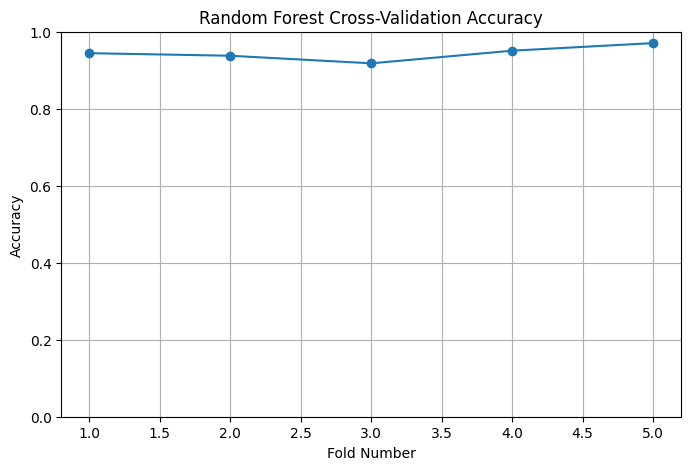


Average Accuracy: 94.42%


In [4]:
#K-fold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

fold_no = 1
for train_index, test_index in kf.split(X, y):
    print(f"\nTraining fold {fold_no}...")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Fold {fold_no} accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred))

    fold_no += 1

# Plot accuracies across folds
plt.figure(figsize=(8,5))
plt.plot(range(1, 6), accuracies, marker='o')
plt.title('Random Forest Cross-Validation Accuracy')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

print(f"\nAverage Accuracy: {np.mean(accuracies)*100:.2f}%")


In [5]:
from sklearn.ensemble import RandomForestClassifier
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X, y)
print("Final model trained on the full dataset.")

Final model trained on the full dataset.


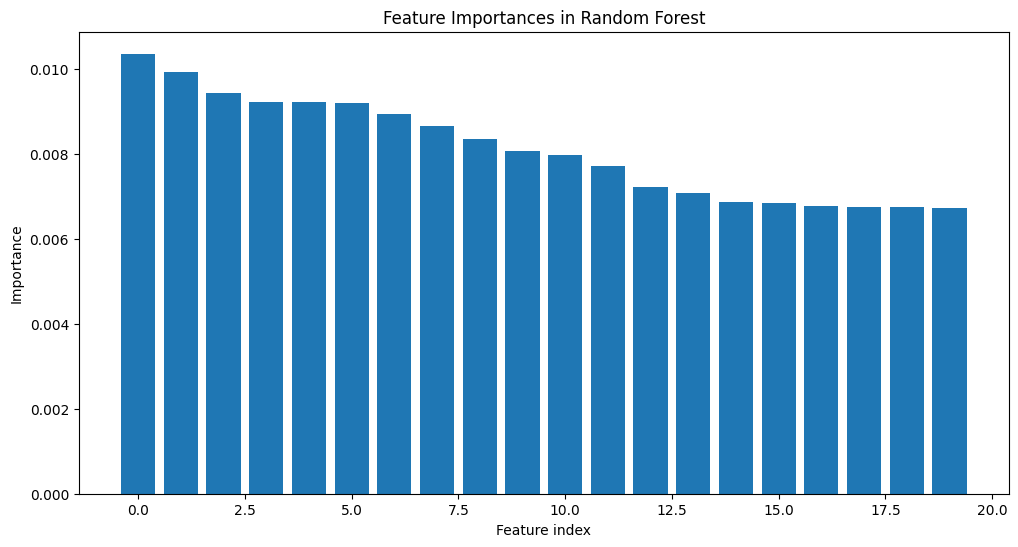

In [7]:
#Visualize metrices
import matplotlib.pyplot as plt
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(20), importances[indices][:20], align='center')
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.show()

In [8]:
#Save model
import joblib
joblib.dump(final_model, 'food_rf_model.pkl')
print("Model saved as food_rf_model.pkl")

Model saved as food_rf_model.pkl


In [9]:
def predict_food_and_nutrition(image_path, model, nutrition_dict, classes):
    import cv2
    img = cv2.imread(image_path)
    features = extract_color_histogram(img)
    features = features.reshape(1, -1)
    pred = model.predict(features)[0]
    nutrition_info = nutrition_dict.get(pred, None)
    return pred, nutrition_info

In [17]:
import pandas as pd
nutrition_df = pd.read_csv('nutrition_data.csv')
print(nutrition_df.columns)

Index(['food', 'serving(g)', 'calories', 'protein(g)', 'carbs(g)', 'fibre(g)',
       'fats(g)', 'sugar(g)', 'type'],
      dtype='object')


In [20]:
# # Step A: Import pandas
# import pandas as pd

# # Step B: Load nutrition CSV
# nutrition_df = pd.read_csv('nutrition_data.csv')
# print(nutrition_df.head())

# # Step C: Define predict_food_and_nutrition function
# def predict_food_and_nutrition(image_path, model, nutrition_dict, classes):
#     import cv2
#     img = cv2.imread(image_path)
#     features = extract_color_histogram(img)
#     features = features.reshape(1, -1)
#     pred = model.predict(features)[0]
#     nutrition_info = nutrition_dict.get(pred, None)
#     return pred, nutrition_info

# # Step D: Convert DataFrame to dictionary
# nutrition_dict = nutrition_df.set_index('food').T.to_dict()

# # Step E: Run inference example
# food_pred, nutrition = predict_food_and_nutrition(
#     "C:/Users/sdgup/OneDrive/Desktop/eatlyze/dataset/kachori/download (1).jpg",
#     final_model,
#     nutrition_dict,
#     classes
# )
# print(f"Food predicted: {food_pred}")
# print(f"Nutrition info: {nutrition}")


          food  serving(g)  calories  protein(g)  carbs(g)  fibre(g)  fats(g)  \
0         roti          40     120.0         3.1      18.5       3.9      3.7   
1          dal         214     222.0        14.0      34.0      13.0      4.2   
2         rice         158     205.0         4.3      45.0       0.6      0.4   
3  masala_dosa          97     168.0         3.9      29.0       0.9      3.7   
4       samosa         100     261.0         3.5      24.0       2.1     17.0   

   sugar(g)     type  
0       3.5  healthy  
1       4.5  healthy  
2       0.1  healthy  
3       0.2  healthy  
4       1.6     junk  
Food predicted: kachori
Nutrition info: {'serving(g)': 20, 'calories': 83.0, 'protein(g)': 1.5, 'carbs(g)': 7.7, 'fibre(g)': 0.6, 'fats(g)': 5.3, 'sugar(g)': 0.2, 'type': 'junk'}


In [25]:
def test_predict_image(image_path, model, class_names, nutrition_dict, true_label=None):
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np

    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image cannot be loaded.")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract features
    features = extract_color_histogram(img)
    features = features.reshape(1, -1)

    # Predict probabilities and class
    probs = model.predict_proba(features)[0]
    pred_index = np.argmax(probs)
    pred_food = class_names[pred_index]
    confidence = probs[pred_index]

    # Get nutrition info for predicted food class
    nutrition_info = nutrition_dict.get(pred_food, None)

    # Display image with prediction info
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    title_str = f"Predicted: {pred_food}\nConfidence: {confidence*100:.2f}%"
    if true_label:
        title_str += f"\nTrue label: {true_label}\nMatch: {'Yes' if pred_food == true_label else 'No'}"
    # Add nutrition info to title
    if nutrition_info:
        nutrition_text = "\n".join([f"{k.capitalize()}: {v}" for k, v in nutrition_info.items()])
        title_str += f"\n\nNutrition:\n{nutrition_text}"
    plt.title(title_str)

    # Bar chart of top 5 predictions
    top5_idx = probs.argsort()[-5:][::-1]
    top5_probs = probs[top5_idx]
    top5_names = [class_names[i] for i in top5_idx]

    plt.subplot(1, 2, 2)
    plt.barh(top5_names[::-1], top5_probs[::-1])
    plt.xlabel("Probability")
    plt.title("Top 5 class probabilities")
    plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()


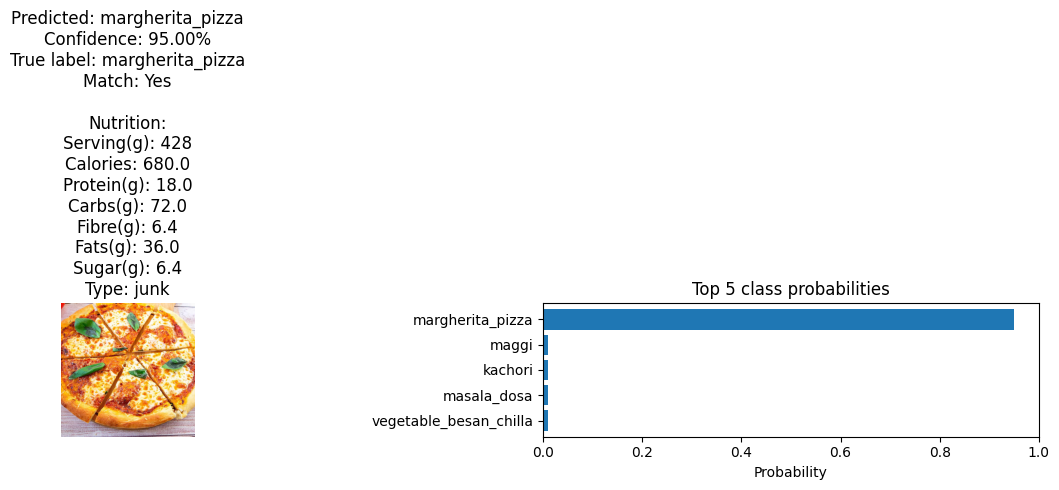

In [26]:
# For example, if testing a kachori image:
test_predict_image("C:/Users/sdgup/OneDrive/Desktop/eatlyze/dataset/margherita_pizza/Image_5.jpg", final_model, classes, nutrition_dict, true_label='margherita_pizza')

In [28]:
#Backend API integration using Flask
from flask import Flask, request, jsonify
import cv2
import numpy as np
import joblib
import pandas as pd
import os

app = Flask(__name__)
model = joblib.load('food_rf_model.pkl')
nutrition_df = pd.read_csv('nutrition_data.csv')
nutrition_dict = nutrition_df.set_index('food').T.to_dict()
classes = list(nutrition_dict.keys())

def extract_color_histogram_from_file(file_stream, bins=(8,8,8)):
    file_bytes = np.asarray(bytearray(file_stream.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180,0,256,0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image provided'}), 400
    image_file = request.files['image']
    features = extract_color_histogram_from_file(image_file)
    features = features.reshape(1, -1)
    pred = model.predict(features)[0]
    conf = max(model.predict_proba(features)[0])
    nutrition = nutrition_dict.get(pred, {})
    return jsonify({
        'food': pred,
        'confidence': conf,
        'nutrition': nutrition
    })

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

C:\Users\sdgup\OneDrive\Desktop\eatlyze\eatlyze_env\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
